# 训练


In [19]:
# # 训练
# setsid python 3rdparty/mmdetection/tools/train.py cfg/ssd_lard.py > train_ssd.log 2>&1 &

# 变量定义


In [1]:
import glob

# 参数
model_name = 'ssd'
model_stru = ''
model_cfg = '_train_val'  # _train_val _train_val_aug
exp_name = f'{model_name}{model_stru}{model_cfg}'
USE_VAL = 'val' in model_cfg
exp_id = '20231106_110914'

# 路径
cfg_path = f'cfg/{model_name}_lard.py'
best_model_path = f'runs/mmdetection/{exp_name}/train/'
files = glob.glob(f'{best_model_path}/best_coco_bbox_mAP_epoch_*.pth')  # TODO: 按epoch数排序
best_model_path = files[0] if files else None
train_log_path = f'runs/mmdetection/{exp_name}/train/{exp_id}/vis_data/scalars.json'

print(f'{exp_name=}')
print(f'{best_model_path=}')
print(f'{train_log_path=}')


exp_name='ssd_train_val'
best_model_path='runs/mmdetection/ssd_train_val/train/best_coco_bbox_mAP_epoch_49.pth'
train_log_path='runs/mmdetection/ssd_train_val/train/20231106_110914/vis_data/scalars.json'


# 日志分析


['lr', 'data_time', 'loss', 'loss_cls', 'loss_bbox', 'time', 'iter', 'memory', 'step']
['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75', 'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l', 'data_time', 'time']
最大map: (49)0.77


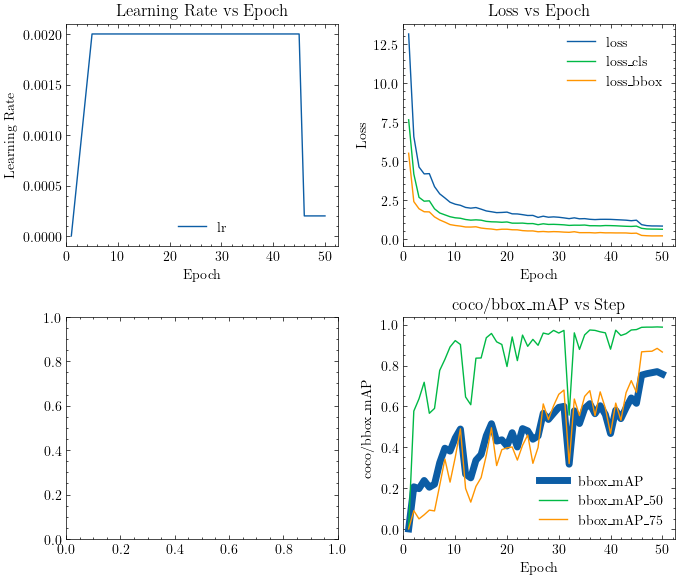

In [3]:
from src.utils.read import read_mmdet_train_log_json
from src.utils.plot import plot_mmdet_ssd_train_log

df_train, df_val = read_mmdet_train_log_json(train_log_path)
plot_mmdet_ssd_train_log(df_train, df_val, exp_name=exp_name)

# 测试


In [2]:
! src/scripts/mmdet_test.sh {cfg_path} {best_model_path} {exp_name}

11/07 21:28:37 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 594185547
    GPU 0: NVIDIA GeForce GTX 1070
    CUDA_HOME: /usr/local/cuda-11.1
    NVCC: Cuda compilation tools, release 11.1, V11.1.74
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 1.10.2+cu111
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,

# 评估


In [8]:
# 提供两种测试评价方案，结果一致
# 方式1: pycocotools
import pandas as pd
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics

# 保存评价结果对象
coco_evals = {}
# 构造dataframe
all_metrics = {}

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/mmdetection/{exp_name}/test/coco_detection/prediction_{data_type}.bbox.json'
    cocoEval = cal_coco_metrics(annotation_file, prediction_file)
    coco_evals[data_type] = cocoEval
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
display(all_metrics.round(3))


# 方式2: eval_metric.py
# ! python 3rdparty/mmdetection/tools/analysis_tools/eval_metric.py \
#     {cfg_path} \
#     runs/mmdetection/{exp_name}/test/coco_detection/prediction_test_synth.pkl \
#     --cfg-options \
#     test_evaluator.format_only=False

正在评价: test_synth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.646
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.621
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

,test_synth,test_real_nominal,test_real_edge
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.563,0.420,0.202
"AP (IoU=0.50, area=all, maxDets=100)",0.876,0.673,0.355
"AP (IoU=0.75, area=all, maxDets=100)",0.618,0.441,0.214
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.087,0.028
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.374,0.271,0.135
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.646,0.638,0.278
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.619,0.459,0.232
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.621,0.482,0.253
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.621,0.482,0.253
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.127,0.060


test_synth
precision.shape=(10, 101, 1, 4, 3), recall.shape=(10, 1, 4, 3)


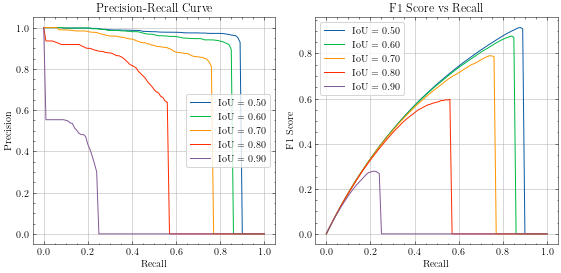

test_real_nominal
precision.shape=(10, 101, 1, 4, 3), recall.shape=(10, 1, 4, 3)


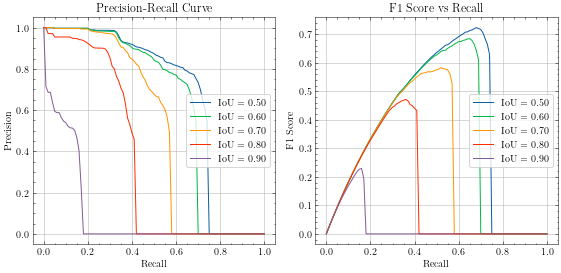

test_real_edge
precision.shape=(10, 101, 1, 4, 3), recall.shape=(10, 1, 4, 3)


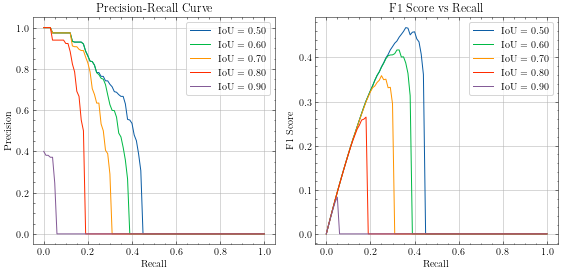

In [4]:
from src.utils.plot import plot_pr_curve

plot_pr_curve(coco_evals, iou_indices=[0, 2, 4, 6, 8], exp_name=exp_name)

# 测速


In [6]:
! src/scripts/mmdet_speed.sh {cfg_path} {best_model_path}

11/06 19:57:48 - mmengine - INFO - before build: 
11/06 19:57:48 - mmengine - INFO - (GB) mem_used: 2.49 | uss: 1.15 | pss: 1.15 | total_proc: 1
Loads checkpoint by local backend from path: runs/mmdetection/ssd_train_val/train/best_coco_bbox_mAP_epoch_49.pth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
11/06 19:57:51 - mmengine - INFO - after build: 
11/06 19:57:51 - mmengine - INFO - (GB) mem_used: 4.45 | uss: 3.59 | pss: 3.60 | total_proc: 1
11/06 19:58:21 - mmengine - INFO - ==================================
11/06 19:58:21 - mmengine - INFO - Done image [500/2000], fps: 47.9 img/s, times per image: 20.9 ms/img, cuda memory: 138 MB
11/06 19:58:21 - mmengine - INFO - (GB) mem_used: 4.48 | uss: 3.64 | pss: 3.65 | total_proc: 1
11/06 19:58:51 - mmengine - INFO - ==================================
11/06 19:58:51 - mmengine - INFO - Done image [1000/2000], fps: 47.9 img/s, times per image: 20.9 ms/img, cuda memory: 138 MB
11/06 19:58:51 - mmengine - 

In [27]:
# 11/06 19:59:53 - mmengine - [4m[97mINFO[0m - ============== Done ==================
# 11/06 19:59:53 - mmengine - [4m[97mINFO[0m - Overall fps: 47.8 img/s, times per image: 20.9 ms/img

# 11/06 20:02:26 - mmengine - [4m[97mINFO[0m - ============== Done ==================
# 11/06 20:02:26 - mmengine - [4m[97mINFO[0m - Overall fps: 49.2 img/s, times per image: 20.3 ms/img

# 11/06 20:03:02 - mmengine - [4m[97mINFO[0m - ============== Done ==================
# 11/06 20:03:02 - mmengine - [4m[97mINFO[0m - Overall fps: 49.1 img/s, times per image: 20.4 ms/img

In [9]:
# 保存结果
all_speed = {
    'test_synth': [20.9, 47.8],  # [average_time, fps]
    'test_real_nominal': [20.3, 49.2],
    'test_real_edge': [20.4, 49.1]
}

# 构建dataframe
all_speed = pd.DataFrame(
    data=all_speed,
    index=['Average inference time (ms)', 'FPS']
)

# 合并测试指标
results = pd.concat([all_metrics, all_speed], axis=0)
results.index.name = 'metrics'
results.to_csv(
    f'results/tables/metrics/metrics_{exp_name}.csv', 
    float_format='%.3f')